In [45]:
import os, gc
import re, string
import calendar
import holidays
import numpy as np
import pandas as pd
import seaborn as sns
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from collections import Counter


from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import ComplementNB
import xgboost as xgb
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss, roc_auc_score, f1_score, confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.naive_bayes import ComplementNB
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
from xgboost import plot_importance
import pickle

%matplotlib inline

print(os.listdir("Datasets"))

['KateSpade_clean.csv', 'UnderArmour.csv', 'ClubMonaco_clean.csv', 'Adidas.csv', '.DS_Store', 'Reebok.csv', 'Reebok_clean.csv', 'ToryBurch.csv', 'ToryBurch_clean.csv', 'ClubMonaco.csv', 'Nike_clean.csv', 'KateSpade.csv', 'NewBalance_clean.csv', 'Nike.csv', 'NewBalance.csv', 'Adidas_clean.csv', 'UnderArmour_clean.csv']


In [42]:
gbm.predict_proba()

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, eval_metric='aucpr', gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=9, min_child_weight=1, missing=None,
       n_estimators=1300, n_jobs=1, nthread=None,
       objective='multi:softprob', random_state=0, reg_alpha=0.5,
       reg_lambda=0.4, scale_pos_weight=1, seed=0, silent=True,
       subsample=1)

## Import the cleaned datasets

In [3]:
Nike = pd.read_csv("Datasets/Nike_clean.csv")
Adidas = pd.read_csv("Datasets/Adidas_clean.csv")
UnderArmour = pd.read_csv("Datasets/UnderArmour_clean.csv")
Reebok = pd.read_csv("Datasets/Reebok_clean.csv")
NewBalance = pd.read_csv("Datasets/NewBalance_clean.csv")
ClubMonaco = pd.read_csv("Datasets/ClubMonaco_clean.csv")
KateSpade = pd.read_csv("Datasets/KateSpade_clean.csv")
ToryBurch = pd.read_csv("Datasets/ToryBurch_clean.csv")

In [4]:
All = [Nike, Adidas, UnderArmour, Reebok, NewBalance, ClubMonaco, KateSpade, ToryBurch]

## Functions for feature engineering:

In [9]:
def str2datetime(df, cols):
    for col in cols:
        try:
            temp= pd.to_datetime(df[col],format='%Y-%m-%d')
        except:
            temp= pd.to_datetime(df[col],format='%m/%d/%Y')
        df.loc[:,col] = temp
    return df

def add_time_features(df, prefix='Posted'):   
    # The string prefix must be 'Posted' or 'End'.
    
    df[prefix+'_year'] = df[prefix+'_date'].dt.year
    df[prefix+'_month'] = df[prefix+'_date'].dt.month
    df[prefix+'_month_year'] = df[prefix+'_date'].dt.to_period('M')
    return df

def add_more_time_features(df, prefix='Posted'):   
    # The string prefix must be 'Posted' or 'End'.
    
    df[prefix+'_dayofweek'] = df[prefix+'_date'].dt.dayofweek
    df[prefix+'_day'] = df[prefix+'_date'].dt.day
    df[prefix+'_dayofyear'] = df[prefix+'_date'].dt.dayofyear
    return df
    
calendar.setfirstweekday(calendar.SATURDAY)
def get_week_of_month(df):
    year = df['Posted_date'].dt.year.values
    month = df['Posted_date'].dt.month.values
    day = df['Posted_date'].dt.day.values
    week_of_month = []
    for i in range(len(year)):
        x = np.array(calendar.monthcalendar(year[i], month[i]))
        week_of_month.append(np.where(x==day[i])[0][0] + 1)
    df['Posted_weekofmonth'] = week_of_month
    return df

def add_holiday_features(df):
    df = df.sort_values(by='Posted_date')
    for name in holidays.US(years=2016).values():
        if 'Observed' in name:
            continue
        else:
            df['days_away' + name] = [0]*df.shape[0]
    
    year_range = range(df['Posted_year'].min(), df['Posted_year'].max()+1)
    for y in year_range:
        for ptr, name in holidays.US(years=y).items():
            if 'Observed' in name:
                continue
            else:
                df.loc[df['Posted_year'] == y,'days_away'+name] = (pd.to_datetime(ptr) - df.loc[df['Posted_year'] == y, 'Posted_date']).dt.days.apply(lambda x: np.exp(-x*x/(20*20)) if x > -20 and x < 20 else 0)
    # The Gaussian distance to the nearest holiday
    df['distance_away_holiday']=df[["days_awayNew Year's Day", 'days_awayMartin Luther King, Jr. Day',
                                    "days_awayWashington's Birthday", 'days_awayMemorial Day',
                                    'days_awayIndependence Day', 'days_awayLabor Day', 'days_awayColumbus Day',
                                    'days_awayVeterans Day', 'days_awayThanksgiving', 'days_awayChristmas Day']].max(axis=1)
    
    return df


def lagged_features(df_long, lag_features, window=7, widths=[4], lag_prefix='lag', lag_prefix_sep='_'):
    """
    Function calculates lagged features (only for columns mentioned in lag_features)
    based on time_feature column. The highest value of time_feature is retained as a row
    and the lower values of time_feature are added as lagged_features
    :param df_long: Data frame (longitudinal) to create lagged features on
    :param lag_features: A list of columns to be lagged
    :param window: How many lags to perform (0 means no lagged feature will be produced)
    :param widths: How many days to roll back and calculate the statistical features
    :param lag_prefix: Prefix to name lagged columns.
    :param lag_prefix_sep: Separator to use while naming lagged columns
    :return: Data Frame with lagged features appended as columns
    """
    if not isinstance(lag_features, list):
        # So that while sub-setting DataFrame, we don't get a Series
        lag_features = [lag_features]

    if window <= 0:
        return df_long

    df_working = df_long[lag_features].copy()
    df_result = df_long.copy()
    for i in range(1, window+1):
        df_temp = df_working.shift(i)
        df_temp.columns = [lag_prefix + lag_prefix_sep + str(i) + lag_prefix_sep + x
                           for x in df_temp.columns]
        df_result = pd.concat([df_result.reset_index(drop=True),
                               df_temp.reset_index(drop=True)],
                               axis=1)
    for width in widths:
        
        window2 = df_working.rolling(window=width)
        window3 = df_long[['Discount_amount']].copy().shift(width - 1).rolling(window=width)

        dataframe = window2.sum()
        dataframe.columns = [lag_prefix+'_past_'+str(width)+'_sum']
        dataframe2 = window3.max()
        dataframe2.columns = [lag_prefix+'_past_'+str(width)+'_max_amount']
        dataframe3 = window3.mean()
        dataframe3.columns = [lag_prefix+'_past_'+str(width)+'_mean_amount']
        df_result = pd.concat([df_result.reset_index(drop=True),
                               dataframe.reset_index(drop=True)],
                               axis=1)
        df_result = pd.concat([df_result.reset_index(drop=True),
                               dataframe2.reset_index(drop=True)],
                               axis=1)
        df_result = pd.concat([df_result.reset_index(drop=True),
                               dataframe3.reset_index(drop=True)],
                               axis=1)

    return df_result


def predict_future(df_long, future_features):
    """
    Function calculates future features (only for columns mentioned in future_features)
    based on time_feature column. The highest value of time_feature is retained as a row
    and the lower values of time_feature are added as future_features
    :param df_long: Data frame (longitudinal) to create future features on
    :param future_features: A list of columns to be forwarded
    :return: Data Frame with future features appended as columns
    """
    if not isinstance(future_features, list):
        # So that while sub-setting DataFrame, we don't get a Series
        future_features = [future_features]

    df_working = df_long[future_features].copy()[::-1]
    df_result = df_long.copy()

    future = df_working.rolling(window=7).max()[::-1]
    future.columns = ['Discount_next_7days']
    future_amount = df_working.rolling(window=14).max()[::-1]
    future_amount.columns = ['Discount_next_14days']

    df_result = pd.concat([df_result.reset_index(drop=True),
                               future.reset_index(drop=True)],
                               axis=1)
    df_result = pd.concat([df_result.reset_index(drop=True),
                               future_amount.reset_index(drop=True)],
                               axis=1)

    return df_result

In [10]:
All_more_features = []
for df in All:
    df = str2datetime(df, ["Posted_date"])
    df = add_time_features(df)
    df = add_more_time_features(df)
    df = add_holiday_features(df)
    df = get_week_of_month(df)
    df['Discount_YesOrNo'] = 1
    df.loc[df['Discount_amount'] == 0, 'Discount_YesOrNo'] = 0
    df = lagged_features(df, ['Discount_YesOrNo'], window=7, widths=[15,30])
    df = predict_future(df, ['Discount_amount'])
    All_more_features.append(df)

In [11]:
Nike_discount = All_more_features[0]
Adidas_discount = All_more_features[1]
UnderArmour_discount = All_more_features[2]
Reebok_discount =All_more_features[3]
NewBalance_discount = All_more_features[4]
ClubMonaco_discount = All_more_features[5]
KateSpade_discount = All_more_features[6]
ToryBurch_discount = All_more_features[7]

/Users/tianbai/anaconda/envs/py3/lib/python3.7/site-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


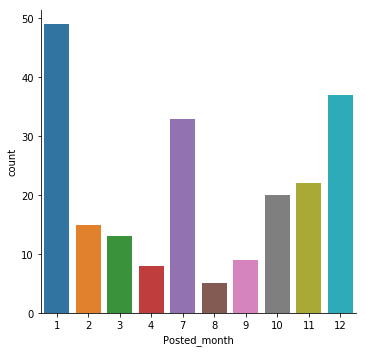

In [12]:
sns.factorplot('Posted_month', data = ClubMonaco_discount[ClubMonaco_discount['Discount_amount'] != 0], kind='count')

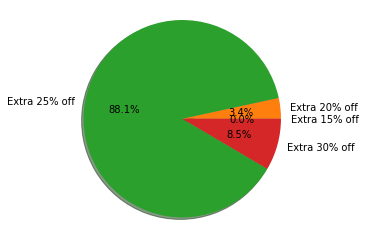

In [14]:
labels = ['Extra 15% off', 'Extra 20% off', 'Extra 25% off', 'Extra 30% off']
sizes = [Nike_discount[(Nike_discount['Posted_month'] == 11)&(Nike_discount['Discount_amount'] == 0.15)].shape[0],
         Nike_discount[(Nike_discount['Posted_month'] == 11)&(Nike_discount['Discount_amount'] == 0.2)].shape[0],
         Nike_discount[(Nike_discount['Posted_month'] == 11)&(Nike_discount['Discount_amount'] == 0.25)].shape[0],
         Nike_discount[(Nike_discount['Posted_month'] == 11)&(Nike_discount['Discount_amount'] == 0.3)].shape[0]
        ]
fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%', shadow=True)
ax1.axis('equal')
plt.show()

/Users/tianbai/anaconda/envs/py3/lib/python3.7/site-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


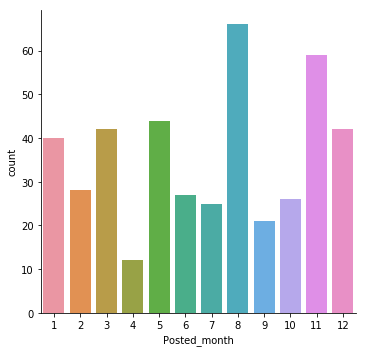

In [15]:
sns.factorplot('Posted_month', data = Nike_discount[Nike_discount['Discount_amount'] != 0], kind='count')

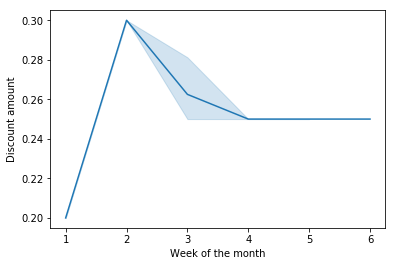

In [17]:
ax = sns.lineplot(x="Posted_weekofmonth", y="Discount_amount",
             data=Nike_discount[(Nike_discount['Posted_month'] == 11) & (Nike_discount['Discount_amount'] != 0)])
ax.set(xlabel='Week of the month', ylabel ='Discount amount')
plt.show()

In [1822]:
ToryBurch_discount['Discount_amount'].unique()

array([0.25, 0.  , 0.3 , 0.2 ])

In [2428]:
MichaelKors_discount['Discount_amount'].unique()

array([0.  , 0.25, 0.1 ])

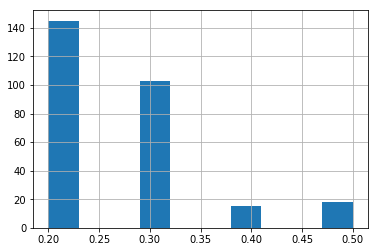

In [18]:
Adidas_discount[Adidas_discount['Discount_amount']!=0]['Discount_amount'].hist()

## Target labeling:

In [19]:
Nike_discount['target'] = 0
Nike_discount.loc[Nike_discount['Discount_next_7days'] == 0.2, 'target'] = 1
Nike_discount.loc[Nike_discount['Discount_next_7days'] == 0.25, 'target'] = 2
Nike_discount.loc[Nike_discount['Discount_next_7days'] == 0.15, 'target'] = 1
Nike_discount.loc[Nike_discount['Discount_next_7days'] == 0.3, 'target'] = 2

In [20]:
Adidas_discount['target'] = 0
Adidas_discount.loc[Adidas_discount['Discount_next_14days'] == 0.2, 'target'] = 1
Adidas_discount.loc[Adidas_discount['Discount_next_14days'] == 0.3, 'target'] = 1
Adidas_discount.loc[Adidas_discount['Discount_next_14days'] == 0.4, 'target'] = 1
Adidas_discount.loc[Adidas_discount['Discount_next_14days'] == 0.5, 'target'] = 1

In [21]:
UnderArmour_discount['target'] = 0
UnderArmour_discount.loc[UnderArmour_discount['Discount_next_7days'] == 0.2, 'target'] = 1
UnderArmour_discount.loc[UnderArmour_discount['Discount_next_7days'] == 0.25, 'target'] = 1

In [22]:
NewBalance_discount['target'] = 0
NewBalance_discount.loc[NewBalance_discount['Discount_next_14days'] == 0.1, 'target'] = 1
NewBalance_discount.loc[NewBalance_discount['Discount_next_14days'] == 0.15, 'target'] = 1
NewBalance_discount.loc[NewBalance_discount['Discount_next_14days'] == 0.2, 'target'] = 2
NewBalance_discount.loc[NewBalance_discount['Discount_next_14days'] == 0.22, 'target'] = 2
NewBalance_discount.loc[NewBalance_discount['Discount_next_14days'] == 0.25, 'target'] = 2
NewBalance_discount.loc[NewBalance_discount['Discount_next_14days'] == 0.3, 'target'] = 2
NewBalance_discount.loc[NewBalance_discount['Discount_next_14days'] == 0.38, 'target'] = 2

In [23]:
ClubMonaco_discount['target'] = 0
ClubMonaco_discount.loc[ClubMonaco_discount['Discount_next_14days'] == 0.1, 'target'] = 1
ClubMonaco_discount.loc[ClubMonaco_discount['Discount_next_14days'] == 0.11, 'target'] = 1
ClubMonaco_discount.loc[ClubMonaco_discount['Discount_next_14days'] == 0.2, 'target'] = 1
ClubMonaco_discount.loc[ClubMonaco_discount['Discount_next_14days'] == 0.25, 'target'] = 1
ClubMonaco_discount.loc[ClubMonaco_discount['Discount_next_14days'] == 0.3, 'target'] = 1
ClubMonaco_discount.loc[ClubMonaco_discount['Discount_next_14days'] == 0.35, 'target'] = 2
ClubMonaco_discount.loc[ClubMonaco_discount['Discount_next_14days'] == 0.4, 'target'] = 2
ClubMonaco_discount.loc[ClubMonaco_discount['Discount_next_14days'] == 0.5, 'target'] = 2

In [24]:
KateSpade_discount['target'] = 0
KateSpade_discount.loc[KateSpade_discount['Discount_next_14days'] == 0.2, 'target'] = 1
KateSpade_discount.loc[KateSpade_discount['Discount_next_14days'] == 0.25, 'target'] = 1
KateSpade_discount.loc[KateSpade_discount['Discount_next_14days'] == 0.3, 'target'] = 1
KateSpade_discount.loc[KateSpade_discount['Discount_next_14days'] == 0.4, 'target'] = 1

In [26]:
Reebok_discount['target'] = 0
Reebok_discount.loc[Reebok_discount['Discount_next_14days'] == 0.15, 'target'] = 1
Reebok_discount.loc[Reebok_discount['Discount_next_14days'] == 0.2, 'target'] = 1
Reebok_discount.loc[Reebok_discount['Discount_next_14days'] == 0.25, 'target'] = 1
Reebok_discount.loc[Reebok_discount['Discount_next_14days'] == 0.3, 'target'] = 1
Reebok_discount.loc[Reebok_discount['Discount_next_14days'] == 0.35, 'target'] = 2
Reebok_discount.loc[Reebok_discount['Discount_next_14days'] == 0.4, 'target'] = 2
Reebok_discount.loc[Reebok_discount['Discount_next_14days'] == 0.5, 'target'] = 2

In [27]:
ToryBurch_discount['target'] = 0
ToryBurch_discount.loc[ToryBurch_discount['Discount_next_14days'] == 0.20, 'target'] = 1
ToryBurch_discount.loc[ToryBurch_discount['Discount_next_14days'] == 0.25, 'target'] = 1
ToryBurch_discount.loc[ToryBurch_discount['Discount_next_14days'] == 0.30, 'target'] = 1

## Forward-chaining Cross-validation:

In [28]:
train_Nike = Nike_discount[(Nike_discount['Posted_date'] < datetime(2018, 6, 1)) & (Nike_discount['Posted_date'] > datetime(2015, 6, 1))]
test_Nike = Nike_discount[(Nike_discount['Posted_date'] >= datetime(2018, 6, 1))]

In [2021]:
train_Adidas = Adidas_discount[(Adidas_discount['Posted_date'] < datetime(2018, 10, 1)) & (Adidas_discount['Posted_date'] > datetime(2016, 5, 1))]
test_Adidas = Adidas_discount[Adidas_discount['Posted_date'] >= datetime(2018, 10, 1)]

In [2153]:
train_UnderArmour = UnderArmour_discount[(UnderArmour_discount['Posted_date'] < datetime(2018, 11, 1)) & (UnderArmour_discount['Posted_date'] > datetime(2017, 12, 1))]
test_UnderArmour = UnderArmour_discount[UnderArmour_discount['Posted_date'] >= datetime(2018, 11, 1)]

In [2199]:
train_NewBalance = NewBalance_discount[(NewBalance_discount['Posted_date'] < datetime(2018, 12, 1)) & (NewBalance_discount['Posted_date'] > datetime(2016, 12, 1))]
test_NewBalance = NewBalance_discount[NewBalance_discount['Posted_date'] >= datetime(2018, 12, 1)]

In [2334]:
train_Ebay = Ebay_discount[(Ebay_discount['Posted_date'] < datetime(2018, 12, 1)) & (Ebay_discount['Posted_date'] > datetime(2016, 12, 1))]
test_Ebay = Ebay_discount[Ebay_discount['Posted_date'] >= datetime(2018, 12, 1)]

In [2423]:
train_ClubMonaco = ClubMonaco_discount[(ClubMonaco_discount['Posted_date'] < datetime(2018, 1, 1)) & (ClubMonaco_discount['Posted_date'] > datetime(2013, 11, 1))]
test_ClubMonaco = ClubMonaco_discount[ClubMonaco_discount['Posted_date'] >= datetime(2018, 1, 1)]

In [2542]:
train_KateSpade = KateSpade_discount[(KateSpade_discount['Posted_date'] < datetime(2018, 12, 1)) & (KateSpade_discount['Posted_date'] > datetime(2011, 6, 1))]
test_KateSpade = KateSpade_discount[KateSpade_discount['Posted_date'] >= datetime(2018, 12, 1)]

In [2579]:
train_MichaelKors = MichaelKors_discount[(MichaelKors_discount['Posted_date'] < datetime(2019, 1, 1)) & (MichaelKors_discount['Posted_date'] > datetime(2013, 11, 1))]
test_MichaelKors = MichaelKors_discount[MichaelKors_discount['Posted_date'] >= datetime(2019, 1, 1)]

In [2746]:
train_Reebok = Reebok_discount[(Reebok_discount['Posted_date'] < datetime(2018, 6, 1)) & (Reebok_discount['Posted_date'] > datetime(2013, 6, 1))]
test_Reebok = Reebok_discount[Reebok_discount['Posted_date'] >= datetime(2018, 6, 1)]

In [ ]:
train_ToryBurch = ToryBurch_discount2[(ToryBurch_discount2['Posted_date'] < datetime(2018, 6, 1)) & (ToryBurch_discount2['Posted_date'] > datetime(2014, 6, 1))]
test_ToryBurch = ToryBurch_discount2[ToryBurch_discount2['Posted_date'] >= datetime(2018, 6, 1)]

------------------------------------
              precision    recall  f1-score   support

           0       0.60      0.97      0.74       138
           1       0.47      0.24      0.32        70
           2       0.92      0.17      0.29        65

   micro avg       0.59      0.59      0.59       273
   macro avg       0.66      0.46      0.45       273
weighted avg       0.64      0.59      0.52       273

------------------------------------
              precision    recall  f1-score   support

           0       0.76      0.88      0.82       147
           1       0.76      0.51      0.61        92
           2       0.46      0.56      0.51        34

   micro avg       0.72      0.72      0.72       273
   macro avg       0.66      0.65      0.65       273
weighted avg       0.72      0.72      0.71       273

------------------------------------
              precision    recall  f1-score   support

           0       0.71      0.84      0.77       143
           1      

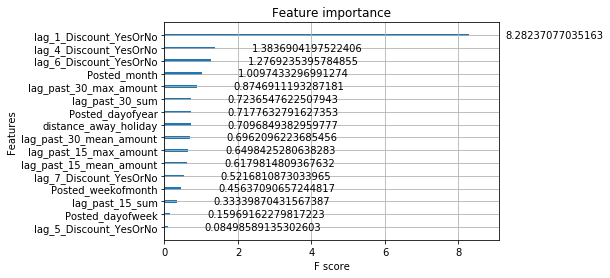

In [29]:
# Define object to handle time series splits
tscv = TimeSeriesSplit(n_splits=3)

# Loop over time series splits, fit model, and test on test data
feature_to_use = [col for col in train_Nike.columns if col not in ['Posted_year', 'Posted_day', 'Discount_amount', 'Posted_date', 'target',
                                                                   'Discount_next_7days', 'Discount_next_14days', 'Discount_YesOrNo',
                                                                   'Posted_month_year',"days_awayNew Year's Day", 'days_awayMartin Luther King, Jr. Day', 
                                                                   "days_awayWashington's Birthday", 'days_awayMemorial Day',
                                                                   'days_awayIndependence Day', 'days_awayLabor Day',
                                                                   'days_awayColumbus Day', 'days_awayVeterans Day',
                                                                   'days_awayThanksgiving', 'days_awayChristmas Day']] # Time information has been captured in Hours, Minutes, Seconds
independent_col = ['target']
for train_index, test_index in tscv.split(train_Nike):
    print('------------------------------------')
    X_train, X_test = train_Nike.iloc[train_index][feature_to_use], train_Nike.iloc[test_index][feature_to_use]
    y_train, y_test = train_Nike.iloc[train_index][independent_col].values.ravel(), train_Nike.iloc[test_index][independent_col].values.ravel()
    
    # Fit logistic regression model to train data and test on test data
    #lr_mod = LogisticRegression(C = 2, penalty='l2', max_iter=1000)  # The value of C should be determined by nested validation
    #lr_mod.fit(X_train, y_train)
    
    #gnb = ComplementNB(alpha=2.0)
    #y_pred = gnb.fit(X_train, y_train).predict(X_test)
    # Fit XGBoost Classifier
    gbm = xgb.XGBClassifier(eval_metric = 'aucpr', reg_lambda = 0.4, reg_alpha = 0.5, colsample_bytree = 1, max_depth =9, n_estimators = 1300,seed=0)
    gbm.fit(X_train, y_train)
    #prediction = gbm.predict(X_test)
    
    
    #y_pred = lr_mod.predict(X_test)
    y_pred = gbm.predict(X_test)
    
    #Print Precision, Recall and F1 scores
    print(classification_report(y_test, y_pred))
    
plot_importance(gbm, importance_type='gain')
plt.rcParams['figure.figsize'] = [10, 10]
plt.show()

In [1954]:
gbm.fit(test_Nike[feature_to_use][:-7], test_Nike['target'][:-7])

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, eval_metric='aucpr', gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=9, min_child_weight=1, missing=None,
       n_estimators=1300, n_jobs=1, nthread=None,
       objective='multi:softprob', random_state=0, reg_alpha=0.5,
       reg_lambda=0.4, scale_pos_weight=1, seed=0, silent=True,
       subsample=1)

In [30]:
prediction_gbm = gbm.predict(test_Nike[feature_to_use])
print(classification_report(test_Nike['target'][:-7], prediction_gbm[:-7]))

              precision    recall  f1-score   support

           0       0.77      0.88      0.82       219
           1       0.65      0.52      0.58        86
           2       0.81      0.57      0.67        51

   micro avg       0.75      0.75      0.75       356
   macro avg       0.74      0.66      0.69       356
weighted avg       0.75      0.75      0.74       356



In [1533]:
prediction_lr = lr_mod.predict(test_Nike[feature_to_use])
print(classification_report(test_Nike['target'][:-7], prediction_lr[:-7]))

              precision    recall  f1-score   support

           0       0.76      0.95      0.85       219
           1       0.61      0.48      0.54        86
           2       0.71      0.24      0.35        51

   micro avg       0.73      0.73      0.73       356
   macro avg       0.69      0.55      0.58       356
weighted avg       0.72      0.73      0.70       356



In [ ]:
prediction_gnb = gnb.predict(test_Nike[feature_to_use])
print(classification_report(test_Nike['target'], prediction_gnb))

In [40]:
feature_target = feature_to_use
feature_target.append('target')

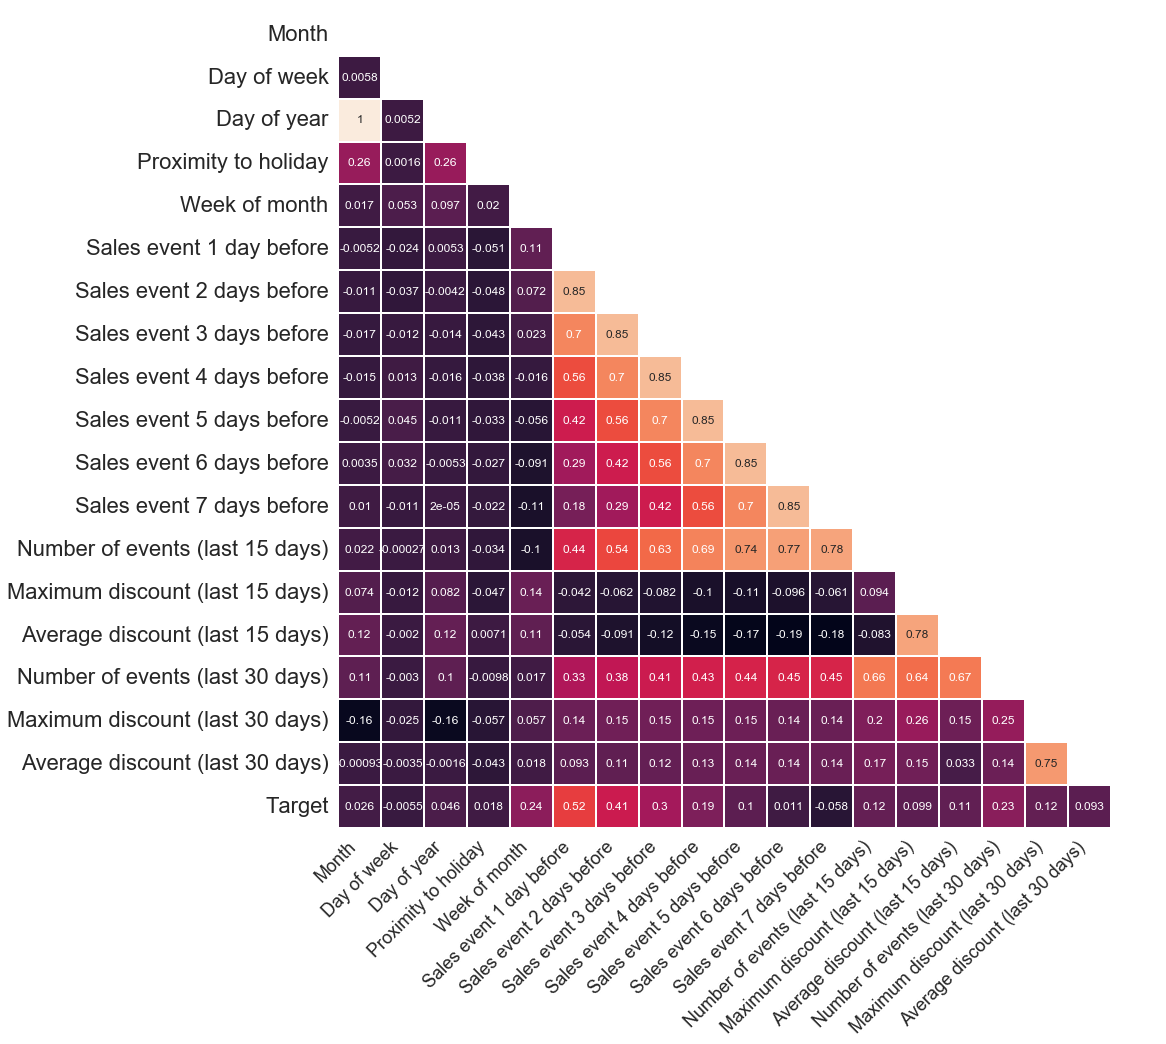

In [41]:
corr = train_Nike[feature_target].corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
sns.set(style="white")
plt.figure(figsize = (32,15))
ax = sns.heatmap(corr, mask=mask, annot=True,
            square=True, linewidths=1,cbar=False)
            #cbar_kws={'label': 'Correlation coefficient'})
ax.set_xticklabels(
    ['Month', 'Day of week', 'Day of year', 'Proximity to holiday', 'Week of month',
    'Sales event 1 day before', 'Sales event 2 days before', 'Sales event 3 days before', 
    'Sales event 4 days before', 'Sales event 5 days before', 'Sales event 6 days before',
    'Sales event 7 days before',
    'Number of events (last 15 days)', 'Maximum discount (last 15 days)', 'Average discount (last 15 days)',
    'Number of events (last 30 days)', 'Maximum discount (last 30 days)', 'Average discount (last 30 days)'],
    rotation=45,
    fontsize=18,
    horizontalalignment='right'
);
ax.set_yticklabels(
    ['Month', 'Day of week', 'Day of year', 'Proximity to holiday', 'Week of month',
    'Sales event 1 day before', 'Sales event 2 days before', 'Sales event 3 days before', 
    'Sales event 4 days before', 'Sales event 5 days before', 'Sales event 6 days before',
    'Sales event 7 days before',
    'Number of events (last 15 days)', 'Maximum discount (last 15 days)', 'Average discount (last 15 days)',
    'Number of events (last 30 days)', 'Maximum discount (last 30 days)', 'Average discount (last 30 days)',
    'Target'],
    fontsize=22,
    verticalalignment = 'center'
);

## Use XGBoost as the final model:

In [3095]:
def Forward_Chaining(df_train, df_test, days, n=3):

# Define object to handle time series splits
    tscv = TimeSeriesSplit(n_splits=n)

# Loop over time series splits, fit model, and test on test data
    feature_to_use = [col for col in df_train.columns if col not in ['Posted_year', 'Posted_day','Discount_amount', 'Posted_date', 'target',
                                                                   'Discount_next_7days', 'Discount_next_14days', 'Discount_YesOrNo',
                                                                   'Posted_month_year',"days_awayNew Year's Day", 'days_awayMartin Luther King, Jr. Day', 
                                                                   "days_awayWashington's Birthday", 'days_awayMemorial Day',
                                                                   'days_awayIndependence Day', 'days_awayLabor Day',
                                                                   'days_awayColumbus Day', 'days_awayVeterans Day',
                                                                   'days_awayThanksgiving', 'days_awayChristmas Day']] # Time information has been captured in Hours, Minutes, Seconds
    independent_col = ['target']
    for train_index, test_index in tscv.split(df_train):
        print('------------------------------------')
        X_train, X_test = df_train.iloc[train_index][feature_to_use], df_train.iloc[test_index][feature_to_use]
        y_train, y_test = df_train.iloc[train_index][independent_col].values.ravel(), df_train.iloc[test_index][independent_col].values.ravel()
    
    # Fit XGBoost Classifier
        gbm = xgb.XGBClassifier(eval_metric = 'aucpr', reg_lambda = 0.4, reg_alpha=0.5, colsample_bytree = 1, max_depth =9, n_estimators = 1300, seed=0)
        gbm.fit(X_train, y_train)
        y_pred = gbm.predict(X_test)
    
    #Print Precision, Recall and F1 scores
        print(classification_report(y_test, y_pred))
    
    plot_importance(gbm, importance_type='gain')
    plt.show()

    gbm.fit(df_train[feature_to_use], df_train['target'])
    prediction = gbm.predict(df_test[feature_to_use][:-days])
    print(classification_report(df_test['target'][:-days], prediction))
    return gbm

def last_train(model, df_test, features):
    model.fit(df_test[features], df_test['target'])
    return model
    

In [2643]:
prediction = gbm.predict(test_MichaelKors[feature_to_use][:-14])
print(classification_report(test_MichaelKors['target'][:-14], prediction))

              precision    recall  f1-score   support

           0       0.65      0.93      0.76        83
           1       0.83      0.41      0.55        71

   micro avg       0.69      0.69      0.69       154
   macro avg       0.74      0.67      0.65       154
weighted avg       0.73      0.69      0.66       154



------------------------------------
              precision    recall  f1-score   support

           0       0.60      0.97      0.74       138
           1       0.47      0.24      0.32        70
           2       0.92      0.17      0.29        65

   micro avg       0.59      0.59      0.59       273
   macro avg       0.66      0.46      0.45       273
weighted avg       0.64      0.59      0.52       273

------------------------------------
              precision    recall  f1-score   support

           0       0.76      0.88      0.82       147
           1       0.76      0.51      0.61        92
           2       0.46      0.56      0.51        34

   micro avg       0.72      0.72      0.72       273
   macro avg       0.66      0.65      0.65       273
weighted avg       0.72      0.72      0.71       273

------------------------------------
              precision    recall  f1-score   support

           0       0.71      0.84      0.77       143
           1      

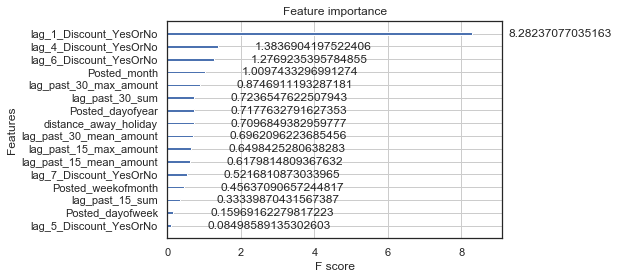

              precision    recall  f1-score   support

           0       0.76      0.82      0.79       219
           1       0.51      0.33      0.40        86
           2       0.48      0.63      0.54        51

   micro avg       0.67      0.67      0.67       356
   macro avg       0.58      0.59      0.58       356
weighted avg       0.66      0.67      0.66       356



In [3096]:
model_7_Nike_2=Forward_Chaining(train_Nike, test_Nike, 7, 3)

In [470]:
print(classification_report(y_test, prediction))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00       119
           1       1.00      0.96      0.98        26

   micro avg       0.99      0.99      0.99       145
   macro avg       1.00      0.98      0.99       145
weighted avg       0.99      0.99      0.99       145



## Output the final models:

In [1962]:
pickle.dump(model_Nike, open('front_end/models/Nike_2019-05-29.sav', 'wb'))

In [1985]:
pickle.dump(model_14_Nike_, open('front_end/models/Nike_14days_2019-05-29.sav', 'wb'))

In [2000]:
pickle.dump(model_7_Adidas, open('front_end/models/Adidas_7days_2019-05-28.sav', 'wb'))

In [2050]:
pickle.dump(model_14_Adidas, open('front_end/models/Adidas_14days_20_2019-05-28.sav', 'wb'))

In [2166]:
pickle.dump(model_7_UnderArmour, open('front_end/models/UnderArmour_7days_20_2019-06-25.sav', 'wb'))

In [2161]:
pickle.dump(model_14_UnderArmour, open('front_end/models/UnderArmour_14days_20_2019-06-25.sav', 'wb'))

In [2228]:
pickle.dump(model_14_NewBalance, open('front_end/models/NewBalance_14days_20_2019-06-30.sav', 'wb'))

In [2426]:
pickle.dump(model_14_ClubMonaco, open('front_end/models/ClubMonaco_14days_30_35_2019-05-37.sav', 'wb'))

In [2540]:
pickle.dump(model_7_KateSpade, open('front_end/models/KateSpade_7days_30_2019-07-07.sav', 'wb'))

In [2547]:
pickle.dump(model_14_KateSpade, open('front_end/models/KateSpade_14days_30_2019-07-07.sav', 'wb'))

In [2576]:
pickle.dump(model_7_MichaelKors, open('front_end/models/MichaelKors_7days_25_2019-06-17.sav', 'wb'))

In [2645]:
pickle.dump(model_14_MichaelKors, open('front_end/models/MichaelKors_14days_25_2019-06-17.sav', 'wb'))

In [2744]:
pickle.dump(model_7_Reebok, open('front_end/models/Reebok_7days_30_35_2019-06-16.sav', 'wb'))

In [2779]:
pickle.dump(model_14_Reebok, open('front_end/models/Reebok_14days_30_35_2019-06-16.sav', 'wb'))

In [2854]:
pickle.dump(model_7_ToryBurch, open('front_end/models/ToryBurch_7days_20_2019-06-30.sav', 'wb'))

In [2902]:
pickle.dump(model_14_ToryBurch, open('front_end/models/ToryBurch_14days_20_2019-06-30.sav', 'wb'))